Copyright 2021 Takehiro Ajioka

### Enviroment

Python 3.6
Anaconda
pytorch==1.9.0_cuda11.1
fastai==2.5.2
tifffile==2020.9.3
opencv-python==4.5.3.56
efficientnet-pytorch==0.7.1
tqdm==4.47.0

# CutOut-Importance

Estimate the importance of a pixel by looking at how much the accuracy decreases when a square mask (filled with 0s) is added to the input after preprocessing. 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [2]:
RNN_Type = 'GRU'
CNN_fix = 'nonFix' #'nonFix'
SEQ_SIZE = 5 # input frame number [-n,n+1]

In [3]:
VALID = 1
TEST = 2

In [4]:
df = pd.read_csv('./data_64_5mice.csv')
df

,Data_ID,Mouse_#
0,20180125_Emx1G6_LR_1,1
1,20180125_Emx1G6_R_1,3
2,20180125_Emx1G6_non_1,2
3,20180126_Emx1G6_LR_1,1
4,20180126_Emx1G6_R_1,3
...,...,...
59,20180411_Emx1G6_non_1,5
60,20180412_Emx1G6_L_1,4
61,20180412_Emx1G6_non_1,5
62,20180413_Emx1G6_L_1,4


In [5]:
def get_filename(mouse_No):
    filename = np.empty(0)
    for i in mouse_No:
        files = df[df['Mouse_#'] == i]['Data_ID'].values
        filename = np.hstack([filename, files])
    return filename

In [6]:
import tifffile
import gc

def load_image(filename):
    raw_image = tifffile.imread(filename)
    X_tmp = (raw_image - raw_image.mean(axis=0)) / raw_image.std() # normalize
    # 3 channel image
    ax = X_tmp.shape
    X = np.zeros([ax[0] - 2, 3, ax[1], ax[2]])
    X[:,0,:,:] = X_tmp[:-2, :, :]
    X[:,1,:,:] = X_tmp[1:-1, :, :]
    X[:,2,:,:] = X_tmp[2:, :, :]
    del X_tmp
    gc.collect();
    return X

In [7]:
from scipy import io

def load_runrest(filename):
    content = io.loadmat(filename)
    Y = content['runrest'][:,1:-1].reshape([-1,1])
    del content
    gc.collect();
    return Y

# Calculation

In [8]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader

In [9]:
BATCH_SIZE = 8 # 64
VER = 'b0'
from efficientnet_pytorch import EfficientNet
cnn = EfficientNet.from_pretrained('efficientnet-'+VER, num_classes=1)

Loaded pretrained weights for efficientnet-b0


In [10]:
FEATURE_SIZE = 1280 # efficient-net b0の時は1280
RNN_UNITS = 128

if RNN_Type == 'RNN':
    rnn = nn.RNN(FEATURE_SIZE, RNN_UNITS, num_layers=2, dropout=0.2, batch_first=True)
elif RNN_Type == 'LSTM':
    rnn = nn.LSTM(FEATURE_SIZE, RNN_UNITS, num_layers=2, dropout=0.2, batch_first=True)
elif RNN_Type == 'GRU':
    rnn = nn.GRU(FEATURE_SIZE, RNN_UNITS, num_layers=2, dropout=0.2, batch_first=True)

In [11]:
# Model
class CNN_RNN(nn.Module):
    def __init__(self,cnn):
        super(CNN_RNN, self).__init__()
        self.cnn = cnn
        self.avgpool = torch.nn.AdaptiveAvgPool2d(1)
        self.rnn = rnn
        self.linear_out = nn.Linear(RNN_UNITS, 1)

    def forward(self, x):
        x = x.reshape(-1, 3, x.shape[3], x.shape[4]) # (batch, channel, size1, size2)
        x = self.cnn.extract_features(x)
        x = self.avgpool(x)
        x = x.reshape(-1, 2*SEQ_SIZE+1, FEATURE_SIZE) # (batch, seq_len, input_size)
        self.rnn.flatten_parameters()
        o_rnn, _ = self.rnn(x)
        output = self.linear_out(o_rnn[:,-1,:])
        return output

In [12]:
# Model
model = CNN_RNN(cnn).cuda()

In [13]:
# Load model
model.load_state_dict(torch.load(f'./stage2_model/model_EfficientNet{VER}_{RNN_Type}_seq{SEQ_SIZE}_valid{VALID}_test{TEST}_{CNN_fix}.pth'))

<All keys matched successfully>

In [14]:
# For prediction
model.eval()

CNN_RNN(
  (cnn): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d(padding=(0, 1, 0, 1), value=0.0)
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d(padding=(1, 1, 1, 1), value=0.0)
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_

In [15]:
class ImageDataset:
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
        
    def __len__(self):
        return (self.targets.shape[0] - 2*SEQ_SIZE)
    
    def __getitem__(self, idx):
        x = torch.tensor(self.features[idx:idx+2*SEQ_SIZE+1, :, :, :], dtype=torch.float)
        y = torch.tensor(self.targets[idx+SEQ_SIZE, :], dtype=torch.float)            
        return x, y

In [16]:
# Cut-Out Setting
SIZE = 128 # Size of the image (power of 2)
RADIUS = 16 # Radius of the cutout, this is the pixel granularity at which the importance is calculated (power of 2)

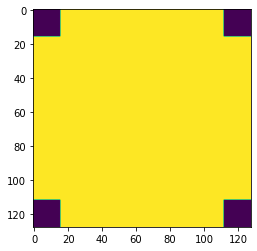

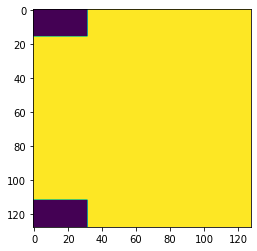

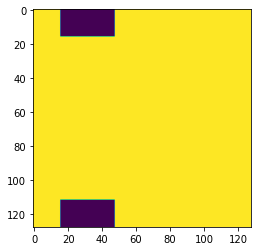

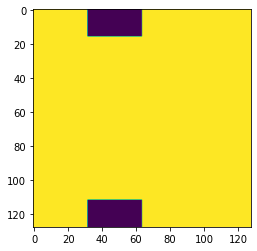

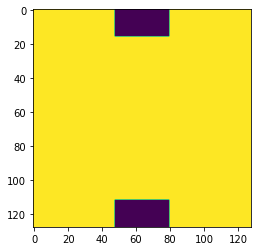

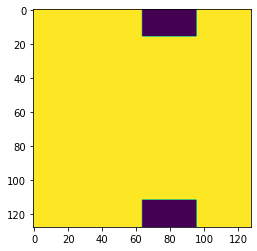

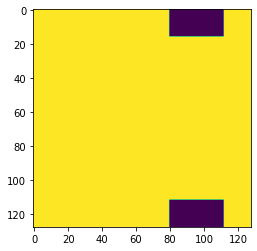

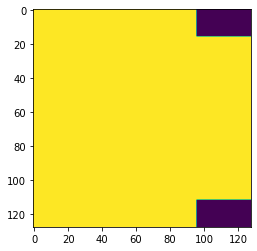

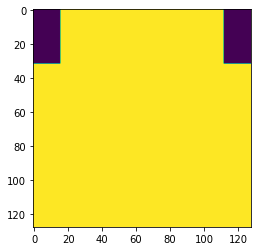

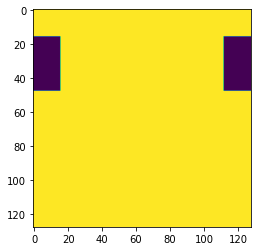

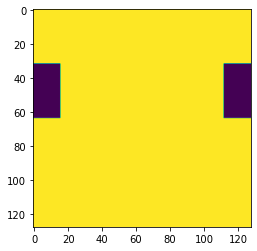

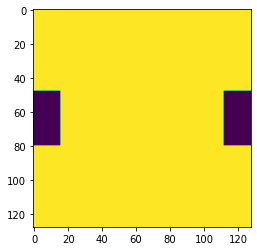

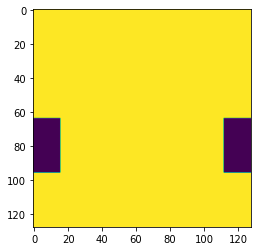

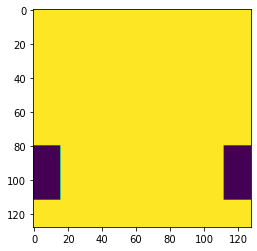

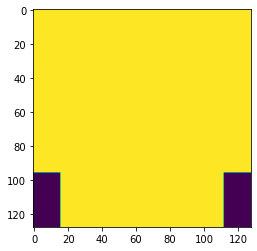

In [17]:
import cv2
max_num = SIZE // RADIUS - 1
masks = []
tmp = np.ones([SIZE, SIZE])
cv2.rectangle(tmp,(0 ,0), (RADIUS-1 ,RADIUS-1), 0, thickness = -1)
cv2.rectangle(tmp,(max_num*RADIUS ,0), ((max_num+1)*RADIUS-1 ,RADIUS-1), 0, thickness = -1)
cv2.rectangle(tmp,(0 ,max_num*RADIUS), (RADIUS-1 ,(max_num+1)*RADIUS-1), 0, thickness = -1)
cv2.rectangle(tmp,(max_num*RADIUS ,max_num*RADIUS), ((max_num+1)*RADIUS-1 ,(max_num+1)*RADIUS-1), 0, thickness = -1)
plt.imshow(tmp)
plt.show()
masks.append(tmp)

# horizontal direction
for i in range(max_num):
    tmp = np.ones([SIZE, SIZE])
    cv2.rectangle(tmp,(i*RADIUS ,0), ((i+2)*RADIUS-1 ,RADIUS-1), 0, thickness = -1)
    cv2.rectangle(tmp,(i*RADIUS ,max_num*RADIUS), ((i+2)*RADIUS-1 ,(max_num+1)*RADIUS-1), 0, thickness = -1)
    plt.imshow(tmp)
    plt.show()
    masks.append(tmp)

# vertical direction
for i in range(max_num):
    tmp = np.ones([SIZE, SIZE])
    cv2.rectangle(tmp,(0, i*RADIUS), (RADIUS-1, (i+2)*RADIUS-1), 0, thickness = -1)
    cv2.rectangle(tmp,(max_num*RADIUS, i*RADIUS), ((max_num+1)*RADIUS-1, (i+2)*RADIUS-1), 0, thickness = -1)
    plt.imshow(tmp)
    plt.show()
    masks.append(tmp)

In [18]:
from tqdm.auto import tqdm

image_path = './data_of_image_64_5mice/'
behavior_path = './data_of_behavior_64_5mice/'

def inference_1_image(X, Y):
    # Show mean image
    fig = plt.figure()
    plt.imshow(X.mean(axis=0).mean(axis=0), cmap="gray")
    # Inference
    ds_i = ImageDataset(X, Y)
    Y_pred = np.zeros([len(ds_i), 1])
    Y_true = np.zeros([len(ds_i), 1])
    infe = DataLoader(ds_i, batch_size=BATCH_SIZE, shuffle=False, num_workers=10, pin_memory=True)
    tqdm_loader = tqdm(infe)
    for idx, (imgs,labels) in enumerate(tqdm_loader):
        bs = labels.shape[0]
        Y_pred[idx*BATCH_SIZE:idx*BATCH_SIZE+bs] = torch.sigmoid(model(imgs.cuda())).cpu().detach().numpy()
        Y_true[idx*BATCH_SIZE:idx*BATCH_SIZE+bs] = labels
    del X, Y, ds_i, infe, tqdm_loader
    gc.collect();
    return Y_pred, Y_true, fig

In [19]:
from sklearn.metrics import roc_auc_score

def calcurate_importance(filename):
    X = load_image(image_path + filename + '.tif')
    Y = load_runrest(behavior_path + filename + '_behavior.mat')
    Y_pred, Y_true, fig = inference_1_image(X, Y)
    Base_AUC = roc_auc_score(Y_true, Y_pred)
    print(Base_AUC)
    plt.title('Base AUC: {:.3f}'.format(Base_AUC))
    plt.show()
    fig.savefig(f'./figure/{filename}_0_baseauc.tiff')
    score = np.ones(len(masks)) * Base_AUC
    for i in range(len(masks)):
        mask = masks[i]
        Y_pred, Y_true, fig = inference_1_image(X * mask, Y)
        AUC = roc_auc_score(Y_true, Y_pred)
        print(AUC)
        plt.title('AUC: {:.3f}, Score: {:.3f}'.format(AUC, Base_AUC - AUC))
        plt.show()
        fig.savefig(f'./figure/{filename}_edge{i+1}_score.tiff')
        score[i] = score[i] - AUC
    return X.mean(axis=0).mean(axis=0), score.transpose()

In [20]:
infer_data = list(get_filename([TEST]))
infer_data

['20180125_Emx1G6_non_1',
 '20180126_Emx1G6_non_1',
 '20180129_Emx1G6_non_1',
 '20180130_Emx1G6_non_1',
 '20180131_Emx1G6_non_1',
 '20180201_Emx1G6_non_1',
 '20180205_Emx1G6_non_1',
 '20180209_Emx1G6_non_1',
 '20180213_Emx1G6_non_1',
 '20180214_Emx1G6_non_1',
 '20180215_Emx1G6_non_1',
 '20180216_Emx1G6_non_1']


0.9593138383399026


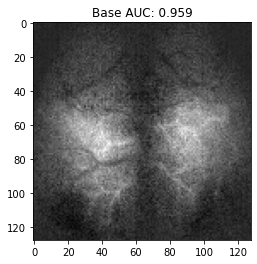


0.9546551695809892


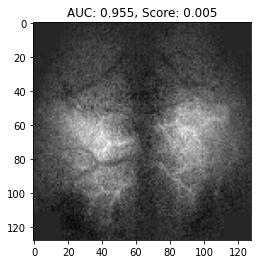


0.9459015519666751


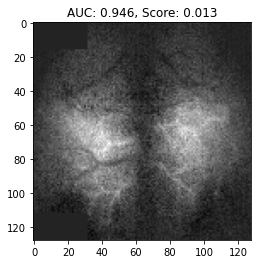


0.9471245314102414


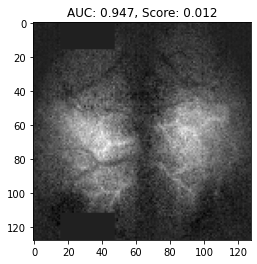


0.9290699622712351


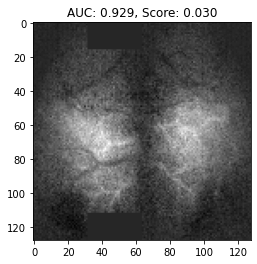


0.9279954180437445


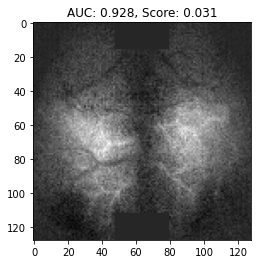


0.9482195091166264


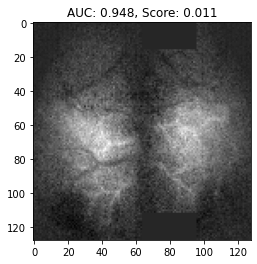


0.9602807320945522


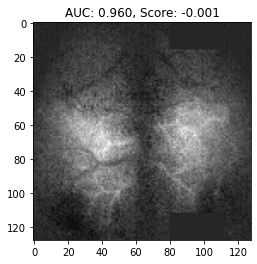


0.9601123250659263


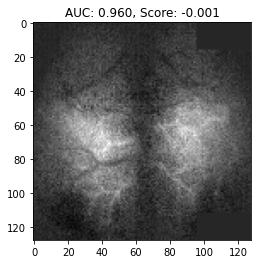


0.9576763773818553


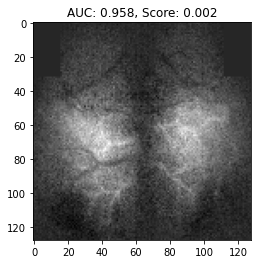


0.9575055418617728


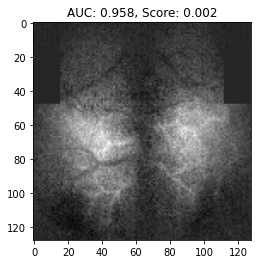


0.9509149449073314


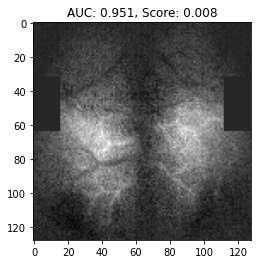


0.9472042732039228


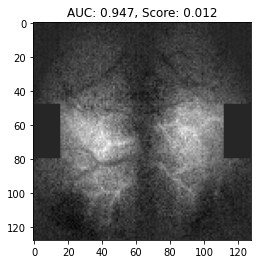


0.9556256238582691


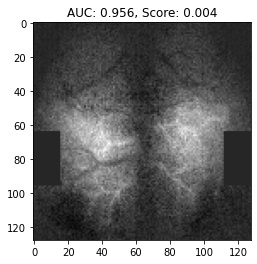


0.9639632927445138


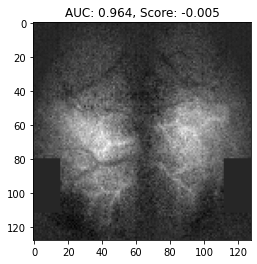


0.9616094394552227


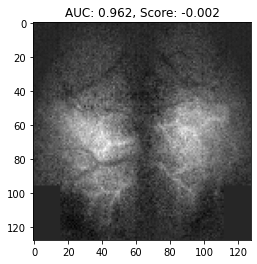

In [21]:
# Calculate importance of an image.
file = infer_data[2]
img, score = calcurate_importance(file)

In [22]:
# Display the resulting importance map
score

array([ 0.00465867,  0.01341229,  0.01218931,  0.03024388,  0.03131842,
        0.01109433, -0.00096689, -0.00079849,  0.00163746,  0.0018083 ,
        0.00839889,  0.01210957,  0.00368821, -0.00464945, -0.0022956 ])